## How transfer learning works

1. Normalize the input images, normalized by the `same mean and standard deviation` that was used during the training of the pre-trained model.

2. Fetch the pre-trained model's architecture. Fetch the  weights for this architecture that arose as a result of being trained on a large dataset.

3. Discard the last few layers of the pre-trained model.

4. Connect the turncated pre-trained model to a freshly initialized layer (or layers) where the weights are randomly initialized. Ensure that the output of the last layer has as many neurons as the classes/outputs we would want to predict.

5. Ensure that the weights of the pre-trained model are not trainable (in other words, frozen/not updated during backpropagation), but that the weights of the  newly initialized layer and the weights connecting it to the output layer are traineble:
  * We do not train the weights of the pretrained model, as we assume those weights are already well learned for the task and hence leverage the learning from a large model. In Summary, we only learn the newly initialized layers for our small dataset.

6. Update the trainable parameters over increasing epochs to fit a model.  

In [2]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms, models, datasets
!pip install torch_summary
from torchsummary import summary

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# Load the VGG16 model
weights = models.VGG16_Weights.DEFAULT
model = models.vgg16(weights=weights).to(device)

summary(model, torch.zeros(1, 3, 224, 224))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:10<00:00, 52.3MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

In [4]:
!pip install torchinfo
from torchinfo import summary

In [5]:

summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Param #              Trainable
VGG (VGG)                                [32, 3, 224, 224]    --                   True
├─Sequential (features)                  [32, 3, 224, 224]    --                   True
│    └─Conv2d (0)                        [32, 3, 224, 224]    1,792                True
│    └─ReLU (1)                          [32, 64, 224, 224]   --                   --
│    └─Conv2d (2)                        [32, 64, 224, 224]   36,928               True
│    └─ReLU (3)                          [32, 64, 224, 224]   --                   --
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   --                   --
│    └─Conv2d (5)                        [32, 64, 112, 112]   73,856               True
│    └─ReLU (6)                          [32, 128, 112, 112]  --                   --
│    └─Conv2d (7)                        [32, 128, 112, 112]  147,584              True
│    └─ReLU (8)                    

In [6]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## IMPLEMENTATION

In [7]:
# 1.Install the required packages
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models, datasets
import matplotlib.pyplot as plt
from PIL import Image
from torch import optim

device = "cuda" if torch.cuda.is_available() else "cpu"


import cv2, glob, numpy as np, pandas as pd
from glob import glob

import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

In [8]:
# 2. Download the dataset and specify the training and test directories
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [9]:
# Download the dataset and unzip it
!kaggle datasets download -d tongpython/cat-and-dog
!unzip cat-and-dog.zip

Streaming output truncated to the last 5000 lines.
  inflating: training_set/training_set/cats/cat.3704.jpg  
  inflating: training_set/training_set/cats/cat.3705.jpg  
  inflating: training_set/training_set/cats/cat.3706.jpg  
  inflating: training_set/training_set/cats/cat.3707.jpg  
  inflating: training_set/training_set/cats/cat.3708.jpg  
  inflating: training_set/training_set/cats/cat.3709.jpg  
  inflating: training_set/training_set/cats/cat.371.jpg  
  inflating: training_set/training_set/cats/cat.3710.jpg  
  inflating: training_set/training_set/cats/cat.3711.jpg  
  inflating: training_set/training_set/cats/cat.3712.jpg  
  inflating: training_set/training_set/cats/cat.3713.jpg  
  inflating: training_set/training_set/cats/cat.3714.jpg  
  inflating: training_set/training_set/cats/cat.3715.jpg  
  inflating: training_set/training_set/cats/cat.3716.jpg  
  inflating: training_set/training_set/cats/cat.3717.jpg  
  inflating: training_set/training_set/cats/cat.3718.jpg  
  infl

In [10]:
# Specify the training and test image folders
train_data_dir = "training_set/training_set"
test_data_dir = "test_set/test_set"

In [11]:
# 3. Provide the class that returns input-output pairs for cats and dogs dataset
class CatsDogs(Dataset):
  def __init__(self, folder):
    cats = glob(folder+'/cats/*.jpg')
    dogs = glob(folder+'/dogs/*.jpg')
    self.fpaths = cats[:500] + dogs[:500]
    self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225])

    from random import shuffle, seed; seed(10);
    shuffle(self.fpaths)
    self.targets = [1 if fpath.split('/')[1].startswith('dog') else 0 for fpath in self.fpaths ]

  def __len__(self): return len(self.fpaths)

  def __getitem__(self, ix):
    f = self.fpaths[ix]
    target = self.fpaths[ix]
    im = (cv2.imread(f)[:,:,::-1])
    im = cv2.resize(im, (224, 224))
    im = torch.tensor(im/255)
    im = im.permute(2, 0, 1)
    im = self.normalize(im)
    return im.float().to(device), torch.tensor([target]).float().to(device)



In [12]:
# 3. Provide the class that returns input-output pairs for cats and dogs dataset
# Corrected by gpt
import cv2
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from glob import glob
from random import shuffle, seed

class CatsDogs(Dataset):
  def __init__(self, folder):
    # Load file paths for cats and dogs
    cats = glob(folder + '/cats/*.jpg')
    dogs = glob(folder + '/dogs/*.jpg')
    self.fpaths = cats[:500] + dogs[:500]

    # Normalize transformations
    self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225])

    # Shuffle file paths for randomness
    seed(10)
    shuffle(self.fpaths)

    # Create targets: 0 for cat, 1 for dog
    self.targets = [1 if fpath.split('/')[-1].startswith('dog') else 0 for fpath in self.fpaths]

  def __len__(self):
    return len(self.fpaths)

  def __getitem__(self, ix):
    # Get file path and corresponding target
    f = self.fpaths[ix]
    target = self.targets[ix]

    # Load and preprocess the image
    im = cv2.imread(f)[:, :, ::-1]  # OpenCV loads in BGR format, convert to RGB
    im = cv2.resize(im, (224, 224))  # Resize image to 224x224
    im = torch.tensor(im / 255.0)  # Normalize pixel values to [0, 1]
    im = im.permute(2, 0, 1)  # Change to (C, H, W)
    im = self.normalize(im)  # Normalize the image

    return im.float().to(device), torch.tensor(target).float().to(device)

In [13]:
# 4. Fetch the images and their labels
data = CatsDogs(train_data_dir)

tensor(0.)


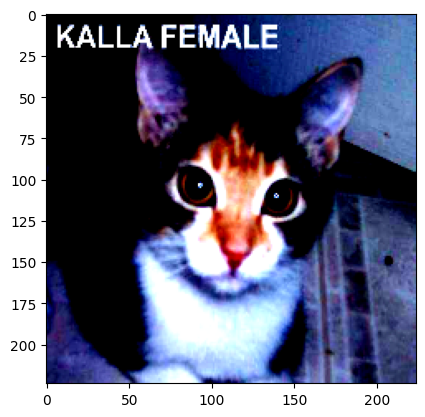

In [14]:
# Let's now inspect a sample image and it's corresponding class
im, label = data[200]
plt.imshow(im.permute(1, 2, 0).cpu())
print(label)

In [15]:
# Define the model
def get_model():
  weights = models.VGG16_Weights.DEFAULT
  model = models.vgg16(weights=weights)

  # Freeze all parameters in the pretrained model
  for param in model.parameters():
    param.requires_grad = False

  # Replace the avgpool module to return a feature map of size 1x1 instead of 7x7
  model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))

  # Define the classifier head of the model
  model.classifier = nn.Sequential(nn.Flatten(),
                                   nn.Linear(512, 128),
                                   nn.ReLU(),
                                   nn.Dropout(0.2),
                                   nn.Linear(128, 1),
                                   nn.Sigmoid()
                                  )


  # Define the loss function and optimizer
  loss_fn = nn.BCELoss
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

  return model.to(device), loss_fn, optimizer


In [16]:
# Initialize the model
model, loss_fn, optimizer = get_model()

# Get a summary of the model using torchifo
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Param #              Trainable
VGG (VGG)                                [32, 3, 224, 224]    --                   Partial
├─Sequential (features)                  [32, 3, 224, 224]    --                   False
│    └─Conv2d (0)                        [32, 3, 224, 224]    (1,792)              False
│    └─ReLU (1)                          [32, 64, 224, 224]   --                   --
│    └─Conv2d (2)                        [32, 64, 224, 224]   (36,928)             False
│    └─ReLU (3)                          [32, 64, 224, 224]   --                   --
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   --                   --
│    └─Conv2d (5)                        [32, 64, 112, 112]   (73,856)             False
│    └─ReLU (6)                          [32, 128, 112, 112]  --                   --
│    └─Conv2d (7)                        [32, 128, 112, 112]  (147,584)            False
│    └─ReLU (8)            

In [17]:
# 6. Define a function to train on a batch, calculate the accuracy and to get the data

# Training function
# Updated train_batch function for binary classification
def train_batch(x, y, model, opt, loss_fn):
  model.train()
  prediction = model(x)

  # Ensure the target is float for binary classification
  y = y.float()

  # Calculate loss
  batch_loss = loss_fn(prediction, y)
  opt.zero_grad()
  batch_loss.backward()
  opt.step()
  return batch_loss.item()


# Accuracy function
# Updated accuracy function for binary classification
@torch.no_grad()
def accuracy(x, y, model):
  model.eval()
  prediction = model(x)

  # For binary classification, threshold at 0.5
  predicted_labels = (prediction > 0.5).float()

  # Compare predicted labels to true labels
  is_correct = (predicted_labels == y).float()  # Convert boolean to float for mean calculation

  return is_correct.cpu().numpy().tolist()

# Get data function
def get_data():
  train = CatsDogs(train_data_dir)
  trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last=True)
  val = CatsDogs(test_data_dir)
  val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last=True)
  return trn_dl, val_dl

In [18]:
def train_batch(x, y, model, opt, loss_fn):
  model.train()
  prediction = model(x)
  batch_loss = loss_fn(prediction, y)
  batch_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  return batch_loss.item()

In [19]:
# Initialize the get_data() and get_model() functions
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [20]:
# 7. Train the model over increasing epochs

train_losses, train_accuracies = [], []
val_accuracies = []
for epoch in range(5):
  print(f"epoch {epoch + 1}/5")
  train_epoch_losses, train_epoch_accuracies = [], []
  val_epoch_accuracies = []

  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
    train_epoch_losses.append(batch_loss)

  train_epoch_loss = np.array(train_epoch_losses).mean()

  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    is_correct = accuracy(x, y , model)
    train_epoch_accuracies.extend(is_correct)

  train_epoch_accuracy = np.mean(train_epoch_accuracies)

  for ix, batch in enumerate(iter(val_dl)):
    x, y = batch
    val_is_correct = accuracy(x, y , model)
    val_epoch_accuracies.extend(val_is_correct)

  val_epoch_accuracy = np.mean(val_epoch_accuracies)

  train_losses.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  val_accuracies.append(val_epoch_accuracy)




epoch 1/5


RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [ ]:
# 8 Plot the training and test accuracy values over increasing epochs

epochs = np.arrange(5) + 1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r',label='Validatoin accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.tile('Training and validation accuracy with VGG16 \nand 1k training data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.95, 1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

##Understanding ResNet architecture



In [21]:
# 1. Define a class with the convolution operation

class ResLayer(nn.Module):
  def __init__(self, ni, no, kernel_size, stride=1):
    super(ResLayer, self).__init__()
    padding = kernel_size - 2
    self.conv = nn.Sequential(
      nn.Conv2d(ni, no, kernel_size, stride, padding=padding),
      nn.ReLU()
    )

   # 2. Define the forward method

  def forward(self, x):
    return self.conv(x) + x



In [23]:
import torch
import torchvision
from torchvision import models

In [26]:
# 1. Load the pretrained model
weights = models.ResNet18_Weights.DEFAULT
model = models.resnet18(weights=weights)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 104MB/s]


In [27]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:

# Get a summary of the model using torchifo
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     --                   True
│    └─BasicBlock (0)                    [32, 64, 56, 56]     --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     36,864               True
│    │    └─BatchNorm2d (bn1)            [32, 64, 56, 56]     128                  True
│    │    └─ReLU (relu)                  [32, 64, 56, 56]     --                   --
│    │    └─Conv2d (conv2)       

In [28]:
# Define the model architecture, loss function and optimizer
def get_model():
  weights = models.ResNet18_Weights.DEFAULT
  model = models.resnet18(weights=weights)

  for param in model.parameters():
    param.requires_grad = False

  model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

  model.fc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 1),
    nn.Sigmoid()
  )
  loss_fn = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  return model.to(device), loss_fn, optimizer